# `why_are_there_missing_values.ipynb`

### Author: Anthony Hein

#### Last updated: 11/23/2021

# Overview:

Why are there missing values?

---

## Setup

In [1]:
from datetime import datetime
import git
import os
import re
from typing import List
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

---

## Load `horses_all.csv`

In [3]:
horses_all = pd.read_csv(f"{BASE_DIR}/data/streamline/horses_all.csv", low_memory=False) 
horses_all.head()

,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,TR,OR,father,mother,gfather,runners,margin,weight,res_win,res_place
0,267255,Going For Broke,3.0,4.0,0.100000,0,P C Haslam,Seb Sanders,1,NaN,...,62.0,62.0,Simply Great,Empty Purse,Pennine Walk,6,1.168254,58,1.0,1.0
1,267255,Pinchincha,3.0,3.0,0.266667,0,Dave Morris,Tony Clark,2,4,...,56.0,65.0,Priolo,Western Heights,Shirley Heights,6,1.168254,60,0.0,1.0
2,267255,Skelton Sovereign,3.0,5.0,0.142857,0,Reg Hollinshead,D Griffiths,3,3,...,40.0,60.0,Contract Law,Mrs Lucky,Royal Match,6,1.168254,55,0.0,0.0
3,267255,Fast Spin,3.0,6.0,0.380952,1,David Barron,Tony Culhane,4,7,...,30.0,59.0,Formidable I,Topwinder,Topsider,6,1.168254,57,0.0,0.0
4,267255,As-Is,3.0,2.0,0.166667,0,Mark Johnston,J Weaver,5,7,...,21.0,65.0,Lomond,Capriati I,Diesis,6,1.168254,60,0.0,0.0


In [4]:
horses_all.shape

(4107315, 27)

---

## Load `races_all.csv`

In [5]:
races_all = pd.read_csv(f"{BASE_DIR}/data/streamline/races_all.csv", low_memory=False) 
races_all.head()

,rid,course,time,date,title,rclass,band,ages,distance,condition,hurdles,prizes,winningTime,prize,metric,countryCode,ncond,class
0,267255,Southwell (AW),03:40,97/01/01,New Year Handicap Class E,Class 5,0-70,3yo,1m,Standard,NaN,"[2752.25, 833.0, 406.5, 193.25]",106.9,4184.0,1609.0,GB,0,5
1,297570,Southwell (AW),12:35,97/01/01,Resolution Claiming Stakes Class F (Div I),Class 6,NaN,4yo+,7f,Standard,NaN,"[1944.0, 544.0, 264.0]",91.0,2752.0,1407.0,GB,0,6
2,334421,Southwell (AW),01:05,97/01/01,One Too Many Median Auction Maiden Apprentices...,Class 6,NaN,4-6yo,1m3f,Standard,NaN,"[2502.0, 702.0, 342.0]",150.7,3546.0,2212.0,GB,0,6
3,366304,Southwell (AW),03:10,97/01/01,Morning Call Selling Stakes Class G Southwell ...,Class 6,NaN,3yo,1m,Standard,NaN,"[2189.0, 614.0, 299.0]",108.6,3102.0,1609.0,GB,0,6
4,13063,Southwell (AW),02:40,97/01/01,Thinking &amp; Drinking Handicap Class E,Class 5,0-70,4yo+,2m½f,Standard,NaN,"[2726.25, 825.0, 402.5, 191.25]",231.4,4144.0,3318.5,GB,0,5


In [6]:
races_all.shape

(396572, 18)

---

## Why are there missing values?

In [7]:
def get_datetime(date: str) -> datetime:
    if date.find(" 00:00") > -1:
        date = date[:date.find(" 00:00")]
    return datetime.strptime(date, '%y/%m/%d')

In [8]:
races_all['datetime'] = races_all['date'].map(get_datetime)
races_all['datetime']

0        1997-01-01
1        1997-01-01
2        1997-01-01
3        1997-01-01
4        1997-01-01
            ...    
396567   1999-12-31
396568   1999-12-31
396569   1999-12-31
396570   1999-12-31
396571   1999-12-31
Name: datetime, Length: 396572, dtype: datetime64[ns]

In [9]:
races_all['datetime'] = pd.to_datetime(races_all['datetime'])
races_all['datetime']

0        1997-01-01
1        1997-01-01
2        1997-01-01
3        1997-01-01
4        1997-01-01
            ...    
396567   1999-12-31
396568   1999-12-31
396569   1999-12-31
396570   1999-12-31
396571   1999-12-31
Name: datetime, Length: 396572, dtype: datetime64[ns]

In [10]:
races_datetimes = races_all[['rid', 'datetime', 'countryCode']]
races_datetimes.head()

,rid,datetime,countryCode
0,267255,1997-01-01,GB
1,297570,1997-01-01,GB
2,334421,1997-01-01,GB
3,366304,1997-01-01,GB
4,13063,1997-01-01,GB


In [11]:
races_datetimes['countryCode'].value_counts()

GB      263644
IE       67344
FR       21560
US       12743
SAF      10990
AU        4297
HK        3624
AE        2444
JP        1686
ARAB      1530
CAN       1366
GER       1357
ARG        770
IT         757
JER        574
BRZ        571
NZ         368
CHI        354
SWE        154
NOR         86
URU         81
TUR         57
SWI         55
GUE         50
DEN         37
SIN         24
SPA         14
CZE         13
KOR          8
KSA          7
BEL          4
BHR          1
MAC          1
PER          1
Name: countryCode, dtype: int64

In [12]:
horses_all_datetimes = horses_all.merge(races_datetimes, how='inner', on='rid')
horses_all_datetimes

,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,father,mother,gfather,runners,margin,weight,res_win,res_place,datetime,countryCode
0,267255,Going For Broke,3.0,4.0,0.100000,0,P C Haslam,Seb Sanders,1,NaN,...,Simply Great,Empty Purse,Pennine Walk,6,1.168254,58,1.0,1.0,1997-01-01,GB
1,267255,Pinchincha,3.0,3.0,0.266667,0,Dave Morris,Tony Clark,2,4,...,Priolo,Western Heights,Shirley Heights,6,1.168254,60,0.0,1.0,1997-01-01,GB
2,267255,Skelton Sovereign,3.0,5.0,0.142857,0,Reg Hollinshead,D Griffiths,3,3,...,Contract Law,Mrs Lucky,Royal Match,6,1.168254,55,0.0,0.0,1997-01-01,GB
3,267255,Fast Spin,3.0,6.0,0.380952,1,David Barron,Tony Culhane,4,7,...,Formidable I,Topwinder,Topsider,6,1.168254,57,0.0,0.0,1997-01-01,GB
4,267255,As-Is,3.0,2.0,0.166667,0,Mark Johnston,J Weaver,5,7,...,Lomond,Capriati I,Diesis,6,1.168254,60,0.0,0.0,1997-01-01,GB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4107310,213759,Bindaree,5.0,2.0,0.285714,0,Nigel Twiston-Davies,Carl Llewellyn,1,NaN,...,Roselier,Flowing Tide,Main Reef I,5,1.101774,73,1.0,1.0,1999-12-31,GB
4107311,213759,Barney Knows,4.0,1.0,0.058824,0,M A Peill,Mr C Bonner,2,7,...,In The Wings,Afeefa,Lyphard,5,1.101774,73,0.0,1.0,1999-12-31,GB
4107312,213759,Hati Roy,6.0,5.0,0.058824,0,Henrietta Knight,Jim Culloty,3,14,...,Lafontaine I,Stage Debut,Decent Fellow,5,1.101774,70,0.0,0.0,1999-12-31,GB
4107313,213759,Rodock,5.0,3.0,0.555556,1,M C Pipe,A P McCoy,4,11,...,Leading Counsel,High Light,Zino,5,1.101774,73,0.0,0.0,1999-12-31,GB


In [13]:
horses_all_datetimes = horses_all_datetimes.sort_values(by='datetime')
horses_all_datetimes[['rid', 'datetime', 'horseName', 'position']]

,rid,datetime,horseName,position
456997,35062,1990-01-01,Proa,40
456971,30382,1990-01-01,Going Gets Tough,3
456970,30382,1990-01-01,Elfast,2
456969,30382,1990-01-01,Another Coral,1
456968,22831,1990-01-01,General Lee,40
...,...,...,...,...
1510222,415048,2020-12-05,Funky Dady,6
1510223,415048,2020-12-05,Bon Retour,7
1510225,415048,2020-12-05,Any Second Now,9
1510218,415048,2020-12-05,The Bosses Oscar,2


In [14]:
horses_all_datetimes = horses_all_datetimes[horses_all_datetimes['countryCode'] == 'IE']
horses_all_datetimes

,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,father,mother,gfather,runners,margin,weight,res_win,res_place,datetime,countryCode
456973,3086,Art Trail,6.0,0.0,0.333333,0,P G Kelly,Mr P G Kelly,1,NaN,...,Aristocracy,Bally Sovereign,Supreme Sovereign,9,1.389415,70,1.0,1.0,1990-01-01,IE
456975,3086,Grangemills,5.0,0.0,0.444444,1,A Redmond,Mr C T G Kinane,3,3,...,Strong Gale,Tengello,Bargello,9,1.389415,69,0.0,1.0,1990-01-01,IE
456981,3086,Satin Sheen,6.0,0.0,0.047619,0,Irwin Kirkpatrick,P J Dreeling,9,NaN,...,Abednego,Miss Magello,Bargello,9,1.389415,68,0.0,0.0,1990-01-01,IE
456980,3086,Doyouseewhatisee,5.0,0.0,0.090909,0,Michael C Gunn,Mr M A Gunn,8,NaN,...,Aliyoun,Friendly Polly,Be Friendly,9,1.389415,69,0.0,0.0,1990-01-01,IE
456979,3086,Indian Jewel,6.0,0.0,0.066667,0,William Patton,Mr R J Patton,7,NaN,...,Arapaho,Daughterly,Tyrant,9,1.389415,71,0.0,0.0,1990-01-01,IE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1510222,415048,Funky Dady,5.0,16.0,0.066667,0,Denis Gerard Hogan,Shane Mulcahy,6,3.75,...,Maresca Sorrento,Non Dadi,Hellios,20,1.360327,59,0.0,0.0,2020-12-05,IE
1510223,415048,Bon Retour,5.0,13.0,0.009901,0,W P Mullins,Adam Short,7,1.25,...,Fame And Glory,Rosy De Cyborg,Cyborg,20,1.360327,63,0.0,0.0,2020-12-05,IE
1510225,415048,Any Second Now,8.0,5.0,0.052632,0,T M Walsh,Mark Walsh,9,3.75,...,Oscar,Pretty Neat,Topanoora,20,1.360327,68,0.0,0.0,2020-12-05,IE
1510218,415048,The Bosses Oscar,5.0,6.0,0.250000,1,Gordon Elliott,Jack Kennedy,2,12,...,Oscar,Cuteasafox,Vinnie Roe,20,1.360327,66,0.0,1.0,2020-12-05,IE


In [15]:
list(horses_all_datetimes.columns)

['rid',
 'horseName',
 'age',
 'saddle',
 'decimalPrice',
 'isFav',
 'trainerName',
 'jockeyName',
 'position',
 'positionL',
 'dist',
 'weightSt',
 'weightLb',
 'overWeight',
 'outHandicap',
 'headGear',
 'RPR',
 'TR',
 'OR',
 'father',
 'mother',
 'gfather',
 'runners',
 'margin',
 'weight',
 'res_win',
 'res_place',
 'datetime',
 'countryCode']

In [16]:
horses_all_datetimes['positionL'] = horses_all_datetimes.apply(
    lambda x: 0 if x['position'] in [1,40] else x['positionL'],
    axis = 1
)

In [17]:
horses_all_datetimes = horses_all_datetimes.drop(columns=['overWeight',
                                                          'outHandicap',
                                                          'headGear',
                                                          'dist',
                                                          'TR',
                                                          'OR',
                                                          'father',
                                                          'mother',
                                                          'gfather'])

In [18]:
list(horses_all_datetimes.columns)

['rid',
 'horseName',
 'age',
 'saddle',
 'decimalPrice',
 'isFav',
 'trainerName',
 'jockeyName',
 'position',
 'positionL',
 'weightSt',
 'weightLb',
 'RPR',
 'runners',
 'margin',
 'weight',
 'res_win',
 'res_place',
 'datetime',
 'countryCode']

In [19]:
horses_all_datetimes['missing'] = horses_all_datetimes.apply(
    lambda x: len(horses_all_datetimes.columns) - x.count(),
    axis = 1
)

In [20]:
horses_all_datetimes['missing_cumsum'] = horses_all_datetimes['missing'].cumsum()

In [21]:
horses_all_datetimes[['missing', 'missing_cumsum']]

,missing,missing_cumsum
456973,1,1
456975,1,2
456981,2,4
456980,2,6
456979,2,8
...,...,...
1510222,0,303840
1510223,0,303840
1510225,0,303840
1510218,0,303840


In [22]:
x = horses_all_datetimes[['rid', 'missing']].groupby('rid').sum().reset_index()
x

,rid,missing
0,3,1
1,6,1
2,9,21
3,20,1
4,21,1
...,...,...
67271,415048,3
67272,415049,3
67273,415050,0
67274,415051,6


In [23]:
x = x.merge(races_datetimes, how='inner', on='rid')
x

,rid,missing,datetime,countryCode
0,3,1,2019-05-18,IE
1,6,1,2004-07-12,IE
2,9,21,1990-09-27,IE
3,20,1,1994-07-14,IE
4,21,1,2015-04-02,IE
...,...,...,...,...
67271,415048,3,2020-12-05,IE
67272,415049,3,2020-12-05,IE
67273,415050,0,2020-12-05,IE
67274,415051,6,2020-12-05,IE


In [24]:
x = x.sort_values(by='datetime')
x

,rid,missing,datetime,countryCode
56930,350951,4,1990-01-01,IE
498,3086,14,1990-01-01,IE
6267,38802,8,1990-01-01,IE
13719,84182,10,1990-01-01,IE
62494,385114,16,1990-01-01,IE
...,...,...,...,...
67270,415047,3,2020-12-05,IE
67271,415048,3,2020-12-05,IE
67272,415049,3,2020-12-05,IE
67273,415050,0,2020-12-05,IE


In [25]:
x['year'] = x['datetime'].map(lambda x: str(x)[:4])
x

,rid,missing,datetime,countryCode,year
56930,350951,4,1990-01-01,IE,1990
498,3086,14,1990-01-01,IE,1990
6267,38802,8,1990-01-01,IE,1990
13719,84182,10,1990-01-01,IE,1990
62494,385114,16,1990-01-01,IE,1990
...,...,...,...,...,...
67270,415047,3,2020-12-05,IE,2020
67271,415048,3,2020-12-05,IE,2020
67272,415049,3,2020-12-05,IE,2020
67273,415050,0,2020-12-05,IE,2020


In [26]:
d = horses_all_datetimes[['rid', 'horseName']].groupby('rid').count().to_dict('index')

In [27]:
x['runners'] = x['rid'].map(lambda r: d[r]['horseName'])
x

,rid,missing,datetime,countryCode,year,runners
56930,350951,4,1990-01-01,IE,1990,4
498,3086,14,1990-01-01,IE,1990,9
6267,38802,8,1990-01-01,IE,1990,7
13719,84182,10,1990-01-01,IE,1990,9
62494,385114,16,1990-01-01,IE,1990,12
...,...,...,...,...,...,...
67270,415047,3,2020-12-05,IE,2020,18
67271,415048,3,2020-12-05,IE,2020,20
67272,415049,3,2020-12-05,IE,2020,12
67273,415050,0,2020-12-05,IE,2020,3


In [28]:
k = x.copy()
k['missing'] = k['missing'] / k['runners']

In [29]:
y = k[['year', 'missing']].groupby('year').mean()
y

,missing
year,
1990,1.397248
1991,1.404400
1992,1.145577
1993,0.867246
1994,0.761212
1995,0.581713
1996,1.215136
1997,1.476536
1998,0.671628


In [44]:
z = x[['runners', 'missing']].groupby('runners').mean().reset_index()
z

,runners,missing
0,2,0.744186
1,3,0.740920
2,4,0.834510
3,5,1.081531
4,6,1.625339
5,7,2.173955
6,8,2.917441
7,9,3.304963
8,10,3.777685
9,11,4.337720


In [46]:
z = z[(z['runners'] >= 3) & (z['runners'] <= 14)]

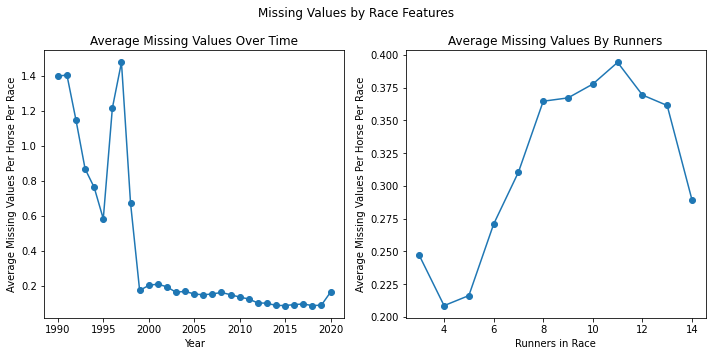

In [49]:
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(1, 2)

fig.suptitle("Missing Values by Race Features")

ax1 = fig.add_subplot(gs[0:1, 0:1])

ax1.set_title("Average Missing Values Over Time")
ax1.plot(np.arange(1990, 2021, 1), y['missing'], marker='o')
ax1.set_xlabel("Year")
ax1.set_ylabel("Average Missing Values Per Horse Per Race")

ax2 = fig.add_subplot(gs[0:1, 1:2])

ax2.set_title("Average Missing Values By Runners")
ax2.plot(z['runners'], z['missing'] / z['runners'], marker='o')
ax2.set_xlabel("Runners in Race")
ax2.set_ylabel("Average Missing Values Per Horse Per Race")

plt.tight_layout()

fig.savefig(f"{BASE_DIR}/figures/missing_values_by_race_features.png")

plt.show()

In [34]:
horses_all_datetimes['year'] = horses_all_datetimes['datetime'].map(lambda x: str(x)[:4])

In [40]:
np.mean(horses_all_datetimes[horses_all_datetimes['year'] == '2020']['RPR'].isnull())

0.16146291410143654

In [41]:
np.mean(horses_all_datetimes[horses_all_datetimes['year'] == '2019']['RPR'].isnull())

0.09543357199681782

In [42]:
np.mean(horses_all_datetimes[horses_all_datetimes['year'] == '2018']['RPR'].isnull())

0.09126519133549835

In [43]:
np.mean(horses_all_datetimes[horses_all_datetimes['year'] == '2017']['RPR'].isnull())

0.10258724428399518

---